# Atmospheric ozone profile modelling

This code is a part of the post mission nalysis segment for [TEK5720](https://www.uio.no/studier/emner/matnat/its/TEK5720/) TUMOR (Targeting Ultraviolet Mid-Ozone layer Radiation) mission

Group Blip-Blop:
* Joachim Thomle Karlsen
* Tobias Mellum
* Michał Jan Odorczuk
* Vytenis Orlauskis
* Yawar Seraj

Code made by Michał Jan Odorczuk

This code nalyses ozone data from various sources to provide mapping model from UV counts registered by the probe, to ozone density profile.

## imports

Please install [pyserial](https://pypi.org/project/pyserial/) and [matplotlib](https://pypi.org/project/matplotlib/)

In [1]:
from os import listdir
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Ozone Lidar data - Andøya 1994-2011

Ozone profile above Andøya, project [DIAL](https://ndacc.larc.nasa.gov/instruments/lidar/ozone-lidar-dial-andoya-norway)

In [2]:
hgl_directory = 'WWW-AIR_1715011702701'
hgls = [hgl_directory + "/" + file for file in listdir(hgl_directory) if file[-3:] == 'hgl']

In [3]:
columns = [
    "timestamp",
    "altitude",
    "ozone_density",
    "ozone_uncertainty",
    "altitude_filter",
    "temperature",
    "air_density",
    "potential_temperature"
]

scales = {
    "ozone_density": 1e10,
    "ozone_uncertainty": 1e10,
    "air_density": 1e17
}

month_lengths = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

data = []
for hgl in hgls:
    with open(hgl, 'r') as f:
        lines = f.readlines()
        start = 0
        while lines[start].strip() != "0":
            start += 1
        start += 1
        for line in lines[start:]:
            line = line.strip()
            if len(line.split()) == 13:
                items = line.split()
                [Y, m, d, H, M] = items[2:7]
                if int(d) > month_lengths[int(m)]:
                    d = month_lengths[int(m)]
                time_string = f'{Y} {m} {d} {int(H)%24} {M}'
                timestamp = pd.to_datetime(time_string, format='%Y %m %d %H %M')
            else:
                data.append([timestamp] + [float(val) for val in line.split()])
dial = pd.DataFrame(data, columns=columns)
for column in scales:
    dial[column] *= scales[column]


Data provided for altitudes above 6 km.

In [4]:
max_alt = 30000
width = 500
altitude_bucket_counter = np.zeros(max_alt // width, dtype='int') # bucket i corresponds to altitude of [250 * i, 250 * (i + 1))
for i in range(max_alt // width):
    altitude_bucket_counter[i] = dial[(dial['altitude']>=width*i)&(dial['altitude']<width*(i + 1))].shape[0]
    print("from", width * i, "to", width * (i + 1), "number of data points:", altitude_bucket_counter[i])

from 0 to 500 number of data points: 0
from 500 to 1000 number of data points: 0
from 1000 to 1500 number of data points: 0
from 1500 to 2000 number of data points: 0
from 2000 to 2500 number of data points: 0
from 2500 to 3000 number of data points: 0
from 3000 to 3500 number of data points: 0
from 3500 to 4000 number of data points: 0
from 4000 to 4500 number of data points: 0
from 4500 to 5000 number of data points: 0
from 5000 to 5500 number of data points: 0
from 5500 to 6000 number of data points: 0
from 6000 to 6500 number of data points: 1
from 6500 to 7000 number of data points: 16
from 7000 to 7500 number of data points: 110
from 7500 to 8000 number of data points: 197
from 8000 to 8500 number of data points: 362
from 8500 to 9000 number of data points: 252
from 9000 to 9500 number of data points: 622
from 9500 to 10000 number of data points: 727
from 10000 to 10500 number of data points: 521
from 10500 to 11000 number of data points: 918
from 11000 to 11500 number of data po

All ozone profile data gathered from DIAL.

$\text{NO}_2$ concentration is of about 4e16 parts per $\text{cm}^3$ as given by [A.J.C. Berkhout, L.F.L. Gast, G.R. van der Hoff, D.P.J. Swart, M. Hoed and M. Allaart (2018)](https://www.epj-conferences.org/articles/epjconf/abs/2018/11/epjconf_ilrc28_10002/epjconf_ilrc28_10002.html), negligible relative to ozone.

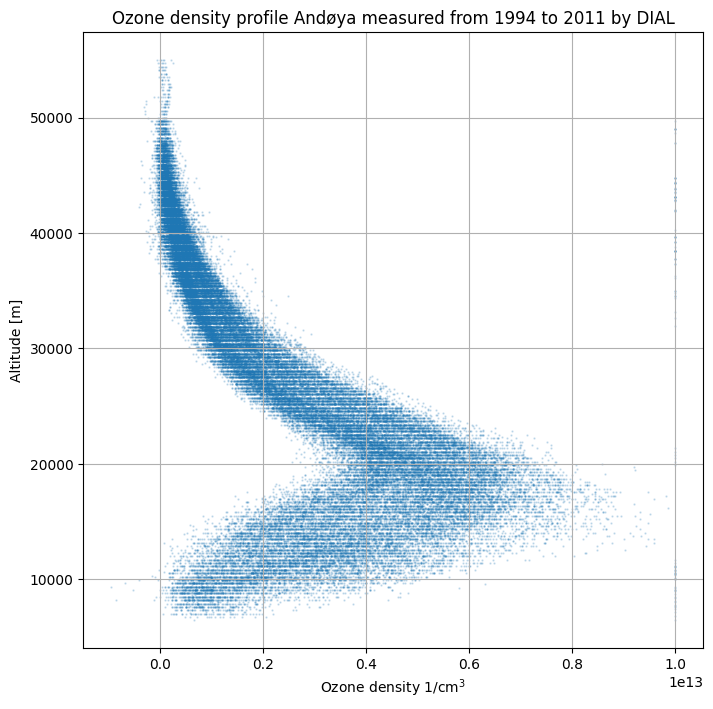

In [5]:
plt.figure(figsize=(8,8))
plt.scatter(dial['ozone_density'], dial['altitude'], s=0.5, alpha=0.2)
plt.title('Ozone density profile Andøya measured from 1994 to 2011 by DIAL')
plt.xlabel('Ozone density $1/\\text{cm}^3$')
plt.ylabel('Altitude [m]')
plt.grid()

Ozone data gathered by DIAL for 7th, 9th and 10th of April 2003 between 8 and 16 UTC.

Data provided for {2003}
Days of April included are {9, 10, 7}


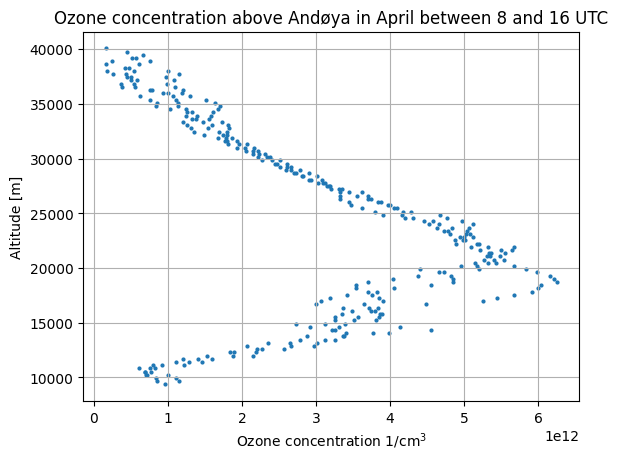

In [6]:
months = ["January" , "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
hour_from, hour_to = 8, 16
month = 4
time = dial['timestamp'].dt
mask = (time.month == month)&(time.hour >= hour_from)&(time.hour <= hour_to)
masked = dial[mask]
years = set(masked['timestamp'].dt.year)
print("Data provided for", years)
days = set(masked['timestamp'].dt.day)
print("Days of April included are", days)
plt.scatter(masked['ozone_density'], masked['altitude'], s=4)
plt.title(f'Ozone concentration above Andøya in {months[month - 1]} between {hour_from} and {hour_to} UTC')
plt.xlabel('Ozone concentration $1/\\text{cm}^3$')
plt.ylabel('Altitude [m]')
plt.grid()

# Ozone absorption cross section

As provided by [Molina, L. T., & Molina, M. J. (1986). Absolute absorption cross sections of ozone in the 185- to 350-nm wavelength range. Journal of Geophysical Research, 91(D13), 14501. doi:10.1029/jd091id13p14501](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/JD091iD13p14501). Cross section for $T = 226\text{K}$ or $-47.15\degree\text{C}$.

Note high variability of the cross section across the range. Values for $\lambda < 350\text{nm}$ were not provided. Because of their low order of magnitude, we assume them to be equal to the value for $\lambda = 350\text{nm}$.

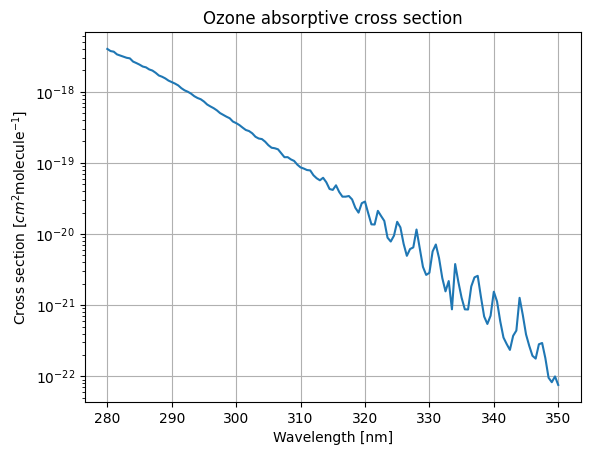

In [7]:
ozoneCS = pd.read_csv("ozoneCrossSection.csv", header=None)
sigma = ozoneCS[1] * 1e-20
plt.plot(ozoneCS[0], sigma)
plt.yscale('log')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Cross section [$cm^2\\text{molecule}^{-1}$]')
plt.title('Ozone absorptive cross section')
plt.grid()

## UV sensitivity LTR390

Ultraviolet sensitivity mask of [Adafruit LTR390 UV sensor](https://optoelectronics.liteon.com/upload/download/DS86-2015-0004/LTR-390UV_Final_%20DS_V1%201.pdf).

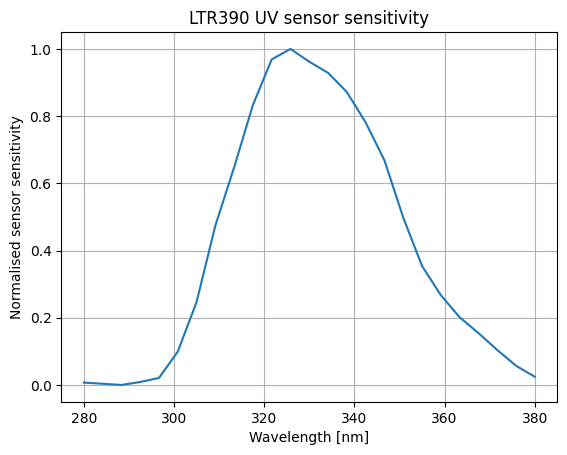

In [8]:
uv_mask = pd.read_csv('LTR390_uvfilter_mask.csv')

plt.plot(uv_mask['lambda'], uv_mask['I'])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalised sensor sensitivity')
plt.title('LTR390 UV sensor sensitivity')
plt.grid()

## Spectral irradiance of a perfect black body at 5800K

Theoretical model for perfect black body at similar surface temperature to the sun, with similar celestial solid angle as seen from Earth's surface. Calculated from Planck's law.

$B = \frac{8\pi h \nu^3}{c^3}\frac{1}{\text{exp}\left( \frac{h\nu}{k_B T} \right) - 1}$

where:
- $\nu = \frac{c}{\lambda}$ are wave frequencies, equal to speed of light divided by wavelength
- $h \approx 6.626\times 10^{-34}$\[Js\] is Planck's constant
- $c \approx 3\times 10^8$\[s\] is the speed of light
- $k_B \approx 1.38\times 10^{-23} [\frac{\text{J}}{\text{K}}]$ is the Boltzmann constant
- $T \approx 5800$\[K\] is the black body temperature

Values are in $[\text{W}\cdot\text{sr}^{-1}\cdot\text{m}^{-2}\text{s}]$. Multiplied by sun's celestial solid angle ($\approx 6.794\times 10^{-5}\text{sr}$) gives spectral irradiance $I$.

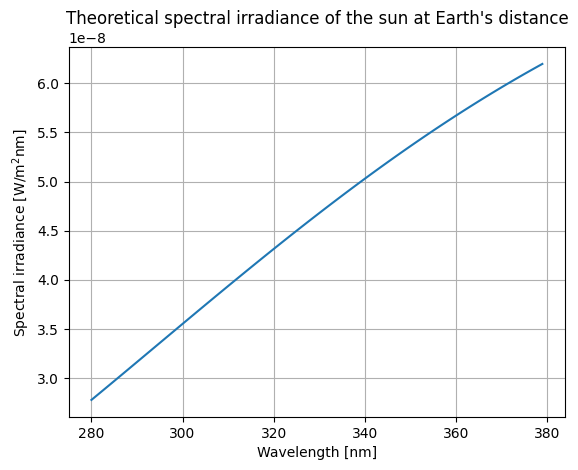

In [9]:
lambdas = np.arange(280, 380) * 1e-9
c = 3e8
nu = c / lambdas
h = 6.626e-34
k = 1.38e-23
T = 5800
solid_angle = 6.794e-5

I0 = 8 * h * np.pi * nu ** 3 / c ** 3 / (np.e ** (nu * h / (k * T)) - 1) * solid_angle * nu / lambdas * 1e-9


plt.plot(lambdas * 1e9, I0)
plt.xlabel("Wavelength [nm]")
plt.ylabel(r"Spectral irradiance [$\text{W}/\text{m}^2\text{nm}$]")
plt.title("Theoretical spectral irradiance of the sun at Earth's distance")
plt.grid()

## Measured solar irradiance

The results presented in this document rely on data from the 2008 Whole Heliosphere Interval (WHI) Solar Irradiance Reference Spectra (SIRS) described in Woods et al. 2009 ([https://doi.org/10.1029/2008GL036373](https://doi.org/10.1029/2008GL036373)). These data were accessed via the LASP Interactive Solar Irradiance Datacenter (LISIRD) ([https://lasp.colorado.edu/lisird/](https://lasp.colorado.edu/lisird/)).

Text(0, 0.5, 'Irradiance $\\text{W}/\\text{m}^2\\text{nm}$')

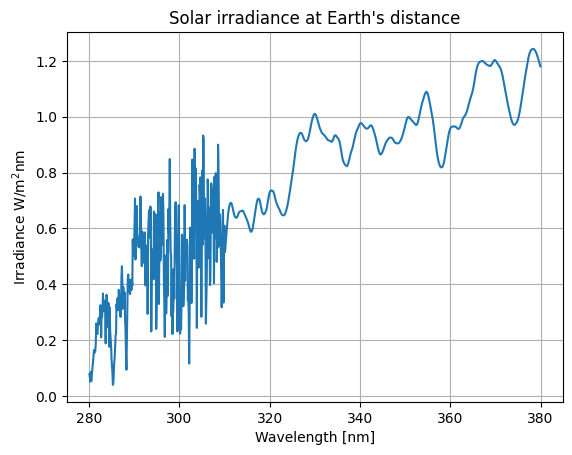

In [10]:
solar_spectrum = pd.read_fwf('ref_solar_irradiance_whi-2008_ver2.dat', skiprows=142, header=None,
            names=['wavelength', 'irradiance1', 'irradiance2', 'irradiance3', 'data source'],
            colspecs=[(0, 8), (9, 20), (21, 32), (33, 44), (45, 48)])
solar_spectrum = solar_spectrum[(solar_spectrum['wavelength']<380)&(solar_spectrum['wavelength']>280)]
solar_irradiance = (solar_spectrum['irradiance1'] + solar_spectrum['irradiance2'] + solar_spectrum['irradiance3']).to_numpy() / 3
solar_wavelengths = solar_spectrum['wavelength'].to_numpy()
plt.plot(solar_wavelengths, solar_irradiance)
plt.grid()
plt.title('Solar irradiance at Earth\'s distance')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance $\\text{W}/\\text{m}^2\\text{nm}$')

## Theoretical normalised registered irradiance

Calculated from theoretical sun irradiance on the Earth's surface, UV sensor mask, and ozone cross section. Does not include other atmospheric components.

$n = -\frac{dI}{dx} \frac{1}{I\sigma}$

$I(x) = I_0 e^{-n\sigma x}$

$\sigma$ is the absorption cross section given in $[\text{cm}^2]$

Typical total vertical ozone column for Andøya is about 300-400 DU. It means distance $x = 3$ to $4$ mm path with molecular density of $n=\frac{p}{RT} \approx \frac{101300\cdot6.02214\times 10^{23}}{8.314\cdot288} \approx 2.604\times 10^{25}\text{m}^-3 = 2.604\times 10^{19}\text{cm}^{-3}$.

For 2024/04/23, 324 DU were registered above Andøya.

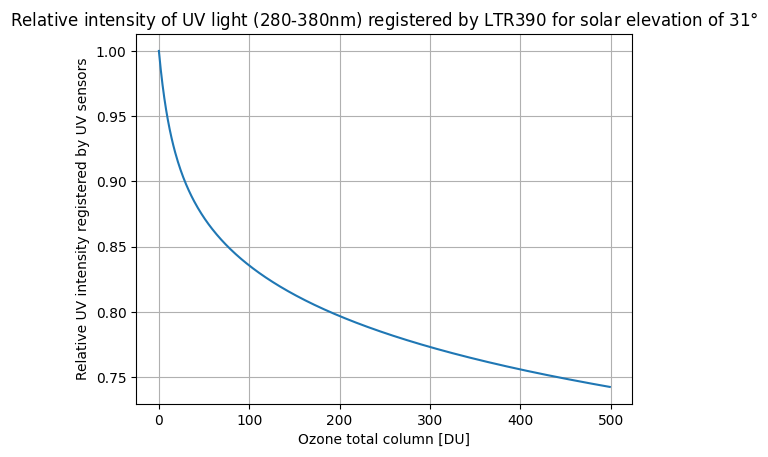

In [11]:
sigma_interp = np.interp(solar_wavelengths * 1e-9, ozoneCS[0] * 1e-9, sigma)
uv_mask_interp = np.interp(solar_wavelengths * 1e-9, uv_mask['lambda'], uv_mask['I'])
DUs = np.arange(500)
dxs = DUs * 1e-3 #cm
n = 2.604e19
dxs = np.array([dxs])
sigma_interp = np.array([sigma_interp]).T

elevation = 31
dxs_angled = dxs / np.sin(np.pi * elevation / 180)
I = np.array([solar_irradiance]).T * np.exp(- n * sigma_interp * dxs_angled)
I_sum = np.array([uv_mask_interp])@I
I_sum_norm = I_sum / I_sum.max()
I_sum_norm = I_sum_norm.T[:,0]



plt.plot(DUs, I_sum_norm)
plt.xlabel('Ozone total column [DU]')
plt.ylabel('Relative UV intensity registered by UV sensors')
plt.title(f'Relative intensity of UV light (280-380nm) registered by LTR390 for solar elevation of ${elevation}\degree$')
plt.grid()
plt.show()

## Conversion from concentration to Dobson units

* Each bucket is of 1000 m width.
* For each of them we compute the average molecular density $n$.
* Sum from top to altitude $h$ gives total ozone column (neglecting ozone above 40 km) count per area.
* Count per area of the total column can be divided by volumetric density at standard pressure $p = 1013\text{hPa}$ and $T = 15\degree \text{C}$, giving total column height.
* Total column height in $10\mu\text{m}$ gives the value in Dobson units.
* Total column is measured only down to 10 km and neglects concentrations above 40 km.

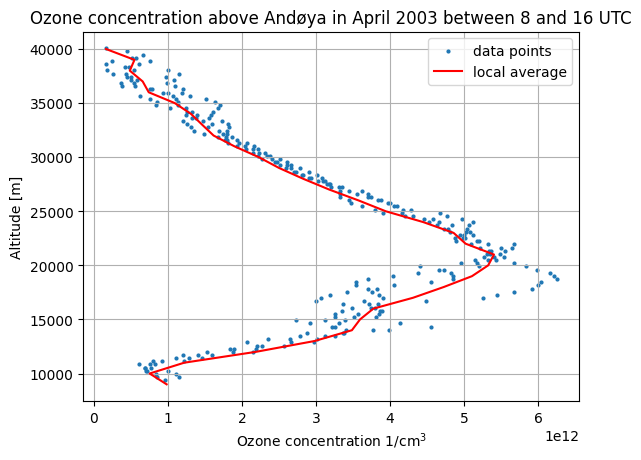

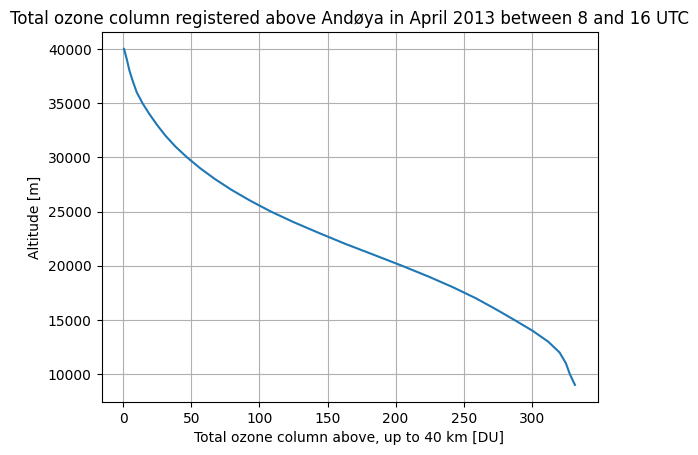

In [12]:
months = ["January" , "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
hour_from, hour_to = 8, 16
month = 4
time = dial['timestamp'].dt
mask = (time.month == month)&(time.hour >= hour_from)&(time.hour <= hour_to)
masked = dial[mask]
plt.scatter(masked['ozone_density'], masked['altitude'], s=4, label = 'data points')
plt.title(f'Ozone concentration above Andøya in {months[month - 1]} 2003 between {hour_from} and {hour_to} UTC')
plt.xlabel('Ozone concentration $1/\\text{cm}^3$')
plt.ylabel('Altitude [m]')
plt.grid()

bucket_width = 1000
bucket_ceilting = 40000
bucket_n = bucket_ceilting // bucket_width + 1
buckets = list(range(bucket_n))
altitudes = masked['altitude']
for bucket in buckets:
    in_bucket = masked[(altitudes>=bucket * bucket_width)&(altitudes<(bucket + 1) * bucket_width)]['ozone_density']
    buckets[bucket] = in_bucket.mean()
bucket_altitudes = list(range(0, bucket_ceilting + bucket_width, bucket_width))
bucket_altitudes = np.array(bucket_altitudes)
plt.plot(buckets, bucket_altitudes, color='red', label = 'local average')
plt.legend()
plt.show()

n = 2.604e19

for i in range(1, len(buckets)):
    buckets[-i-1] += buckets[-i]
total_column = np.array(buckets) * bucket_width * 100 # how many cm^3 can stack in the bucket width
total_column *= 1000 / n
plt.plot(total_column, bucket_altitudes)
plt.xlabel('Total ozone column above, up to 40 km [DU]')
plt.ylabel('Altitude [m]')
plt.title(f'Total ozone column registered above Andøya in {months[month - 1]} 2013 between {hour_from} and {hour_to} UTC')
plt.grid()

(0.76, 0.88)

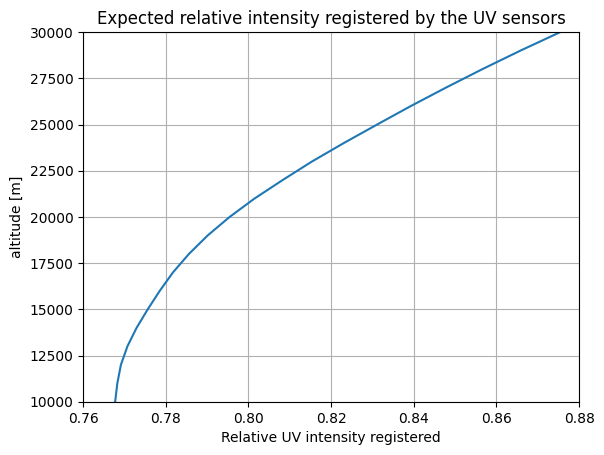

In [13]:
I_interploated = np.interp(total_column, DUs, I_sum_norm)
plt.plot(I_interploated, bucket_altitudes)
plt.xlabel('Relative UV intensity registered')
plt.ylabel('altitude [m]')
plt.title('Expected relative intensity registered by the UV sensors')
plt.grid()
plt.ylim((10000,30_000))
plt.xlim((0.76, 0.88))